<a href="https://colab.research.google.com/github/CalculatedContent/WW_PGD/blob/main/examples/WW_PGD_TinyTransformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Using device: cuda
Chars: 1115394

=== BASELINE (AdamW) ===
[BASE][Epoch 1/35] train_loss=2.4084 val_loss=2.4332 train_ppl=11.12 val_ppl=11.40 BLEU4=0.1419
[BASE][Epoch 2/35] train_loss=2.3265 val_loss=2.3603 train_ppl=10.24 val_ppl=10.59 BLEU4=0.1790
[BASE][Epoch 3/35] train_loss=2.2314 val_loss=2.2822 train_ppl=9.31 val_ppl=9.80 BLEU4=0.1635
[BASE][Epoch 4/35] train_loss=2.0996 val_loss=2.1611 train_ppl=8.16 val_ppl=8.68 BLEU4=0.1846
[BASE][Epoch 5/35] train_loss=1.9801 val_loss=2.0785 train_ppl=7.24 val_ppl=7.99 BLEU4=0.1120
[BASE][Epoch 6/35] train_loss=1.8816 val_loss=2.0024 train_ppl=6.56 val_ppl=7.41 BLEU4=0.1693
[BASE][Epoch 7/35] train_loss=1.8123 val_loss=1.9433 train_ppl=6.12 val_ppl=6.98 BLEU4=0.2180
[BASE][Epoch 8/35] train_loss=1.7424 val_loss=1.8990 train_ppl=5.71 val_ppl=6.68 BLEU4=0.1880
[BASE][Epoch 9/35] train_loss=1.7000 val_loss=1.8

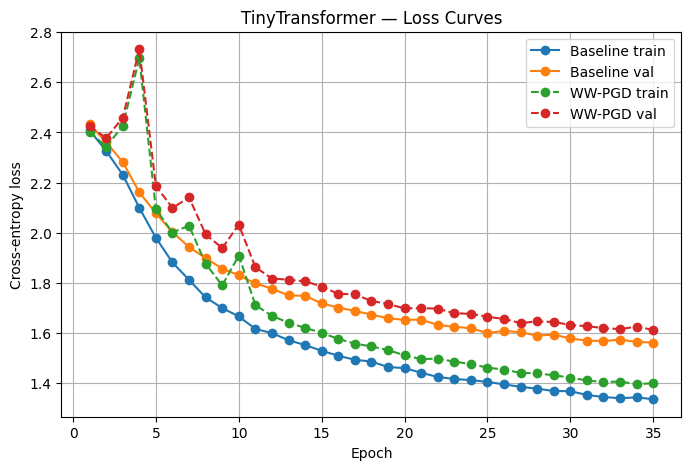

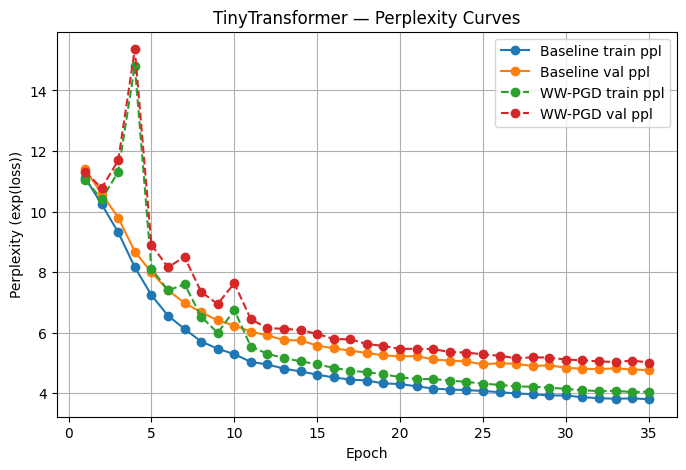

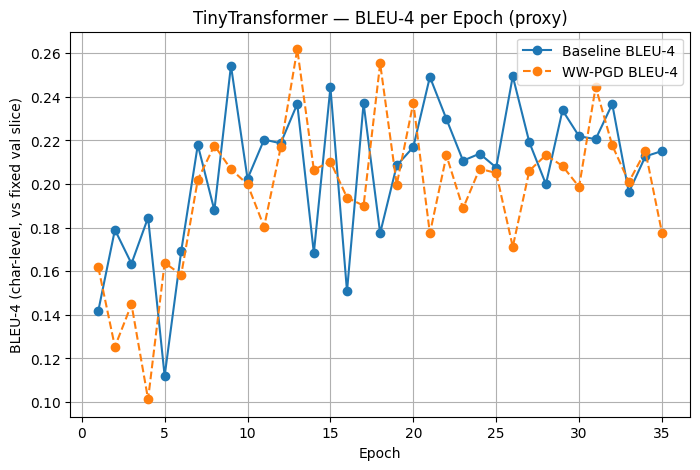

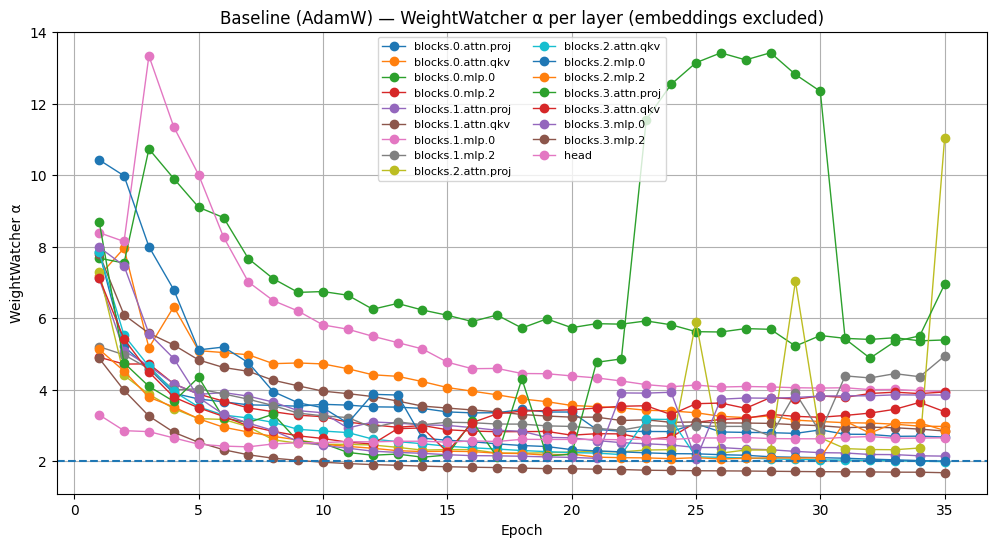

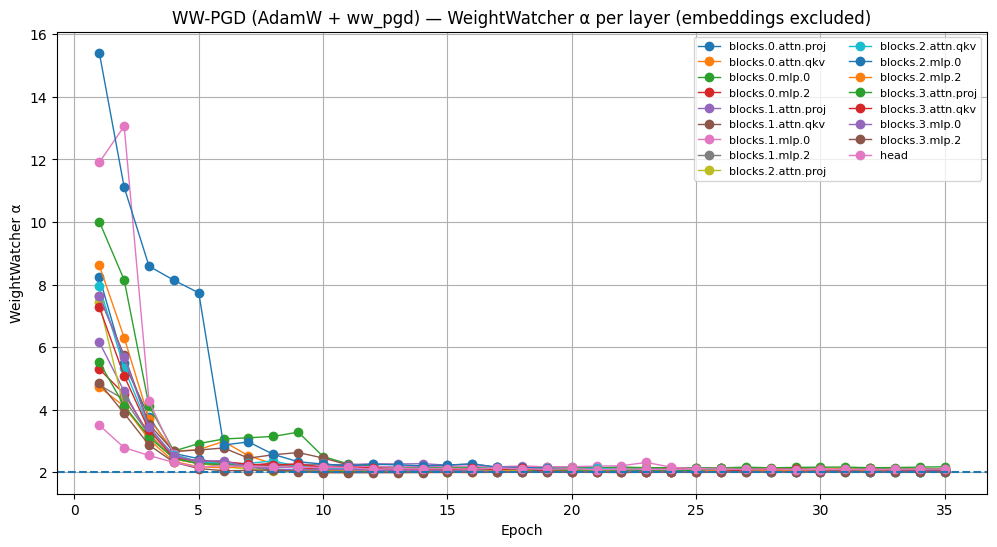


Timing:
Baseline seconds: 161.5
WW-PGD seconds  : 177.1

=== Sample (Baseline) ===

Had to heard takes me trust, havisa!
And sing aims to the thus?

DUKE OF YORK:
Say, thou the Echild king: good men to so, here,
But, by me that the time confessishorool,
Writ it do I'll pay to apon home.

May of me:
He broother, so close was agreat
Unthilly: 'tis advoided: I say meet, they, my lord!

First Nurselmner: she will to he speak, the hath the eacuty,
Go not to do. God me hence to friendinguy.

PAULINAM:
Ble shall, your suffice abs men hath track'd revengs.

HENRY BOLINGBROKE:
So have hencrealus; will be any of govern.

KING EDWARD IV:
Do lieg sooth seping grief?

MARCIUS:
What we not

=== Sample (WW-PGD) ===

O, but gave't: to to liet
No hath would grizen fearl offf beseming fame
Did rich in divime him attile the bulies onels:
Which cheekn you the peace foond the stay?
Ah, makene they wars father her adoss!

This detelling, brazenest was alone, friends!
And I wiver to stears up invy,
And best

In [7]:
# ======================================================
# GOOGLE COLAB CELL: TinyTransformer (char-level) baseline vs ww_pgd
#  - Track TRUE WeightWatcher alpha per weight-matrix layer (per epoch)
#  - Plot layer-wise alpha trajectories for BASELINE and WW-PGD on SEPARATE plots
#  - DO NOT plot embedding-layer alphas
#  - Add per-epoch "accuracy-like" metrics:
#       * Perplexity (train + val) from cross-entropy loss
#       * BLEU-4 (char-level) of generated sample vs a fixed reference slice
# ======================================================

!pip -q install weightwatcher
!pip -q install git+https://github.com/CalculatedContent/WW_PGD.git

import os, math, time, random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import Counter

import weightwatcher as ww
import ww_pgd

# -----------------------------
# Repro + device
# -----------------------------
seed = 123
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# -----------------------------
# Download Tiny Shakespeare (char-level)
# -----------------------------
data_path = "/content/tinyshakespeare.txt"
if not os.path.exists(data_path):
    !wget -q -O /content/tinyshakespeare.txt https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare.txt || true
    # fallback (karpathy path)
    if not os.path.exists("/content/tinyshakespeare.txt"):
        !wget -q -O /content/tinyshakespeare.txt https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

text = open(data_path, "r", encoding="utf-8").read()
print("Chars:", len(text))

chars = sorted(list(set(text)))
vocab_size = len(chars)
stoi = {ch:i for i,ch in enumerate(chars)}
itos = {i:ch for ch,i in stoi.items()}

def encode(s): return [stoi[c] for c in s]
def decode(ix): return "".join([itos[i] for i in ix])

data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]

# -----------------------------
# Batch sampling
# -----------------------------
block_size = 128     # context length
batch_size = 64

def get_batch(split):
    d = train_data if split == "train" else val_data
    ix = torch.randint(0, len(d) - block_size - 1, (batch_size,))
    x = torch.stack([d[i:i+block_size] for i in ix])
    y = torch.stack([d[i+1:i+block_size+1] for i in ix])
    return x.to(device), y.to(device)

@torch.no_grad()
def estimate_loss(model, eval_iters=50):
    model.eval()
    out = {}
    for split in ["train", "val"]:
        losses = []
        for _ in range(eval_iters):
            xb, yb = get_batch(split)
            _, loss = model(xb, yb)
            losses.append(loss.item())
        out[split] = float(np.mean(losses))
    model.train()
    return out

def safe_perplexity(loss_value: float) -> float:
    # Perplexity = exp(cross_entropy); clamp for safety
    if not np.isfinite(loss_value):
        return float("nan")
    loss_value = float(np.clip(loss_value, 0.0, 50.0))
    return float(math.exp(loss_value))

# -----------------------------
# Tiny Transformer (nanoGPT-style, char-level)
# -----------------------------
class CausalSelfAttention(nn.Module):
    def __init__(self, n_embd, n_head, dropout):
        super().__init__()
        assert n_embd % n_head == 0
        self.n_head = n_head
        self.head_dim = n_embd // n_head
        self.qkv = nn.Linear(n_embd, 3*n_embd, bias=False)
        self.proj = nn.Linear(n_embd, n_embd, bias=False)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer("mask", torch.tril(torch.ones(block_size, block_size)).view(1,1,block_size,block_size))

    def forward(self, x):
        B,T,C = x.shape
        qkv = self.qkv(x)
        q,k,v = qkv.split(C, dim=2)
        q = q.view(B,T,self.n_head,self.head_dim).transpose(1,2)
        k = k.view(B,T,self.n_head,self.head_dim).transpose(1,2)
        v = v.view(B,T,self.n_head,self.head_dim).transpose(1,2)

        att = (q @ k.transpose(-2,-1)) / math.sqrt(self.head_dim)
        att = att.masked_fill(self.mask[:,:,:T,:T] == 0, float("-inf"))
        att = F.softmax(att, dim=-1)
        att = self.dropout(att)

        y = att @ v
        y = y.transpose(1,2).contiguous().view(B,T,C)
        y = self.dropout(self.proj(y))
        return y

class Block(nn.Module):
    def __init__(self, n_embd, n_head, dropout):
        super().__init__()
        self.ln1 = nn.LayerNorm(n_embd)
        self.attn = CausalSelfAttention(n_embd, n_head, dropout)
        self.ln2 = nn.LayerNorm(n_embd)
        self.mlp = nn.Sequential(
            nn.Linear(n_embd, 4*n_embd),
            nn.GELU(),
            nn.Linear(4*n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

class TinyTransformer(nn.Module):
    def __init__(self, vocab_size, n_embd=192, n_head=6, n_layer=4, dropout=0.1):
        super().__init__()
        self.tok_emb = nn.Embedding(vocab_size, n_embd)                 # embedding (exclude from alpha plots)
        self.pos_emb = nn.Parameter(torch.zeros(1, block_size, n_embd)) # parameter (exclude from alpha plots)
        self.drop = nn.Dropout(dropout)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head, dropout) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.head = nn.Linear(n_embd, vocab_size, bias=False)

        nn.init.normal_(self.pos_emb, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        B,T = idx.shape
        x = self.tok_emb(idx) + self.pos_emb[:, :T, :]
        x = self.drop(x)
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.head(x)
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(B*T, -1), targets.view(B*T))
        return logits, loss

    @torch.no_grad()
    def generate(self, idx, max_new_tokens=200):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            next_ix = torch.multinomial(probs, num_samples=1)
            idx = torch.cat([idx, next_ix], dim=1)
        return idx

# -----------------------------
# WeightWatcher alpha tracking (per-layer, per-epoch), excluding embeddings
# -----------------------------
def ww_alphas_per_layer(model, epoch: int):
    watcher = ww.WeightWatcher(model=model)
    df = watcher.analyze(detX=True, randomize=False, plot=False)

    name_col = "longname" if "longname" in df.columns else ("name" if "name" in df.columns else None)
    if name_col is None or "alpha" not in df.columns:
        return {}

    out = {}
    for _, row in df.iterrows():
        lname = str(row[name_col]).lower()

        # EXCLUDE embeddings / positional embeddings
        if ("tok_emb" in lname) or ("pos_emb" in lname) or ("embedding" in lname):
            continue

        a = row.get("alpha", float("nan"))
        try:
            a = float(a)
        except:
            continue
        if not np.isfinite(a) or a <= 0 or a == -1.0:
            continue

        out[str(row[name_col])] = a

    return out

def plot_alpha_history(alpha_hist: dict, title: str):
    plt.figure(figsize=(12,6))
    for lname, vals in alpha_hist.items():
        x = np.arange(1, len(vals)+1)
        y = np.array(vals, dtype=float)
        plt.plot(x, y, marker="o", linewidth=1, label=lname)
    plt.axhline(2.0, linestyle="--")
    plt.xlabel("Epoch")
    plt.ylabel("WeightWatcher α")
    plt.title(title)
    plt.grid(True)
    plt.legend(fontsize=8, ncol=2)
    plt.show()

# -----------------------------
# BLEU-4 (char-level) — simple, self-contained
# -----------------------------
def _ngrams(seq, n):
    return [tuple(seq[i:i+n]) for i in range(len(seq)-n+1)] if len(seq) >= n else []

def bleu4_char(candidate: str, reference: str, max_n: int = 4, smooth: float = 1e-9) -> float:
    """
    Simple BLEU-n (default BLEU-4) on characters with smoothing.
    This is a lightweight, consistent proxy for "how close is generated text to reference".
    Not intended as a definitive language metric.
    """
    cand = list(candidate)
    ref = list(reference)

    # brevity penalty
    c = len(cand)
    r = len(ref)
    if c == 0:
        return 0.0
    bp = 1.0 if c > r else math.exp(1.0 - (r / max(c, 1)))

    precisions = []
    for n in range(1, max_n+1):
        c_ngrams = Counter(_ngrams(cand, n))
        r_ngrams = Counter(_ngrams(ref, n))
        if sum(c_ngrams.values()) == 0:
            precisions.append(smooth)
            continue
        clipped = 0
        for g, cnt in c_ngrams.items():
            clipped += min(cnt, r_ngrams.get(g, 0))
        p_n = (clipped + smooth) / (sum(c_ngrams.values()) + smooth)
        precisions.append(p_n)

    score = bp * math.exp(sum(math.log(p) for p in precisions) / max_n)
    return float(score)

# Fixed reference slice for BLEU comparison (validation text slice)
REF_LEN = 400  # compare on first 400 chars (keep small/fast)
ref_text = decode(val_data[:REF_LEN].tolist())

# -----------------------------
# Training runner: baseline vs ww_pgd
# -----------------------------
def run_experiment(use_wwpgd: bool, num_epochs=8, steps_per_epoch=200, lr=3e-4,
                   warmup_epochs=1, ramp_epochs=3, apply_every_epochs=1,
                   cayley_eta=0.12, blend_eta=0.08, min_tail=16,
                   gen_len=400):
    model = TinyTransformer(vocab_size=vocab_size).to(device)
    base_opt = torch.optim.AdamW(model.parameters(), lr=lr, betas=(0.9, 0.95), weight_decay=0.1)

    if use_wwpgd:
        cfg = ww_pgd.WWTailConfig(
            enable_tail_pgd=True,
            min_tail=min_tail,
            q=1.0,
            blend_eta=blend_eta,
            cayley_eta=cayley_eta,
            use_detx=True,
            warmup_epochs=warmup_epochs,
            ramp_epochs=ramp_epochs,
            enable_trap_pgd=False,
            verbose=False,
        )
        opt = ww_pgd.WWPGDWrapper(
            model=model,
            base_optimizer=base_opt,
            tail_config=cfg,
            apply_every_epochs=apply_every_epochs,
            ww_logs=None,
        )
        ww_opt = opt
    else:
        opt = base_opt
        ww_opt = None

    train_losses, val_losses = [], []
    train_ppls, val_ppls = [], []
    bleu_scores = []
    alpha_hist = {}

    t0 = time.time()

    for epoch in range(num_epochs):
        model.train()
        for step in range(steps_per_epoch):
            xb, yb = get_batch("train")
            _, loss = model(xb, yb)
            opt.zero_grad(set_to_none=True)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()

        # epoch-boundary ww_pgd projection
        if use_wwpgd and ww_opt is not None:
            ww_opt.apply_tail_projection(epoch=epoch, num_epochs=num_epochs)

        # eval losses
        losses = estimate_loss(model, eval_iters=30)
        tr_loss = losses["train"]
        va_loss = losses["val"]
        train_losses.append(tr_loss)
        val_losses.append(va_loss)

        train_ppls.append(safe_perplexity(tr_loss))
        val_ppls.append(safe_perplexity(va_loss))

        # layer-wise WeightWatcher α (exclude embeddings)
        alpha_now = ww_alphas_per_layer(model, epoch)
        all_layers = set(alpha_hist.keys()) | set(alpha_now.keys())
        for lname in sorted(all_layers):
            if lname not in alpha_hist:
                alpha_hist[lname] = [float("nan")] * epoch
            alpha_hist[lname].append(alpha_now.get(lname, float("nan")))
        for lname in alpha_hist.keys():
            if len(alpha_hist[lname]) < epoch + 1:
                alpha_hist[lname].append(float("nan"))

        # generation + BLEU-4 (char-level) per epoch
        context = torch.zeros((1,1), dtype=torch.long, device=device)
        gen = decode(model.generate(context, max_new_tokens=gen_len)[0].tolist())
        gen = gen[:REF_LEN]  # align length to reference slice
        bleu = bleu4_char(gen, ref_text, max_n=4)
        bleu_scores.append(bleu)

        print(f"[{'WW-PGD' if use_wwpgd else 'BASE'}][Epoch {epoch+1}/{num_epochs}] "
              f"train_loss={tr_loss:.4f} val_loss={va_loss:.4f} "
              f"train_ppl={train_ppls[-1]:.2f} val_ppl={val_ppls[-1]:.2f} "
              f"BLEU4={bleu_scores[-1]:.4f}")

    dt = time.time() - t0

    # final sample (for display)
    context = torch.zeros((1,1), dtype=torch.long, device=device)
    sample = decode(model.generate(context, max_new_tokens=600)[0].tolist())

    return {
        "model": model,
        "train_loss": np.array(train_losses),
        "val_loss": np.array(val_losses),
        "train_ppl": np.array(train_ppls),
        "val_ppl": np.array(val_ppls),
        "bleu4": np.array(bleu_scores),
        "alpha_hist": alpha_hist,
        "seconds": dt,
        "sample": sample
    }

# -----------------------------
# Run baseline vs ww_pgd
# -----------------------------
EPOCHS = 35
SPE = 200

print("\n=== BASELINE (AdamW) ===")
res_base = run_experiment(
    use_wwpgd=False,
    num_epochs=EPOCHS,
    steps_per_epoch=SPE,
    lr=3e-4,
)

print("\n=== WW-PGD (AdamW + ww_pgd) ===")
res_pgd = run_experiment(
    use_wwpgd=True,
    num_epochs=EPOCHS,
    steps_per_epoch=SPE,
    lr=3e-4,
    warmup_epochs=1,
    ramp_epochs=3,
    apply_every_epochs=1,
    cayley_eta=0.5,
    blend_eta=0.5,
    min_tail=16,
)

# -----------------------------
# Plots: Loss
# -----------------------------
epochs = np.arange(1, EPOCHS+1)

plt.figure(figsize=(8,5))
plt.plot(epochs, res_base["train_loss"], marker="o", label="Baseline train")
plt.plot(epochs, res_base["val_loss"], marker="o", label="Baseline val")
plt.plot(epochs, res_pgd["train_loss"], marker="o", linestyle="--", label="WW-PGD train")
plt.plot(epochs, res_pgd["val_loss"], marker="o", linestyle="--", label="WW-PGD val")
plt.xlabel("Epoch")
plt.ylabel("Cross-entropy loss")
plt.title("TinyTransformer — Loss Curves")
plt.grid(True)
plt.legend()
plt.show()

# -----------------------------
# Plots: Perplexity
# -----------------------------
plt.figure(figsize=(8,5))
plt.plot(epochs, res_base["train_ppl"], marker="o", label="Baseline train ppl")
plt.plot(epochs, res_base["val_ppl"], marker="o", label="Baseline val ppl")
plt.plot(epochs, res_pgd["train_ppl"], marker="o", linestyle="--", label="WW-PGD train ppl")
plt.plot(epochs, res_pgd["val_ppl"], marker="o", linestyle="--", label="WW-PGD val ppl")
plt.xlabel("Epoch")
plt.ylabel("Perplexity (exp(loss))")
plt.title("TinyTransformer — Perplexity Curves")
plt.grid(True)
plt.legend()
plt.show()

# -----------------------------
# Plots: BLEU-4 (char-level proxy) per epoch
# -----------------------------
plt.figure(figsize=(8,5))
plt.plot(epochs, res_base["bleu4"], marker="o", label="Baseline BLEU-4")
plt.plot(epochs, res_pgd["bleu4"], marker="o", linestyle="--", label="WW-PGD BLEU-4")
plt.xlabel("Epoch")
plt.ylabel("BLEU-4 (char-level, vs fixed val slice)")
plt.title("TinyTransformer — BLEU-4 per Epoch (proxy)")
plt.grid(True)
plt.legend()
plt.show()

# -----------------------------
# Plot TRUE layer-wise alphas (separate plots; embeddings excluded)
# -----------------------------
plot_alpha_history(res_base["alpha_hist"], "Baseline (AdamW) — WeightWatcher α per layer (embeddings excluded)")
plot_alpha_history(res_pgd["alpha_hist"],  "WW-PGD (AdamW + ww_pgd) — WeightWatcher α per layer (embeddings excluded)")

print("\nTiming:")
print(f"Baseline seconds: {res_base['seconds']:.1f}")
print(f"WW-PGD seconds  : {res_pgd['seconds']:.1f}")

print("\n=== Sample (Baseline) ===")
print(res_base["sample"][:1200])

print("\n=== Sample (WW-PGD) ===")
print(res_pgd["sample"][:1200])